In [15]:
import numpy as np
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
import sys
sys.path.append('../')
import matplotlib
%config InlineBackend.figure_format = 'retina'
font = {'size': 18, 'family': 'serif'}
axislabelfontsize = 'large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)

In [16]:
# samples_4 = np.load('./bpl_wfld_4.npz')
samples_5 = np.load('./bpl_wfld_5.npz')

{'w': [0.6, 0.9], 'log10_f_rh': [-5.5, -4.5], 'x_0': [-5.0, -1.30103], 'x_1': [-5.0, -1.30103], 'x_2': [-5.0, -1.30103], 'y_0': [-6, -2], 'y_1': [-6, -2], 'y_2': [-6, -2], 'y_3': [-6, -2], 'y_4': [-6, -2]}
Removed no burn in


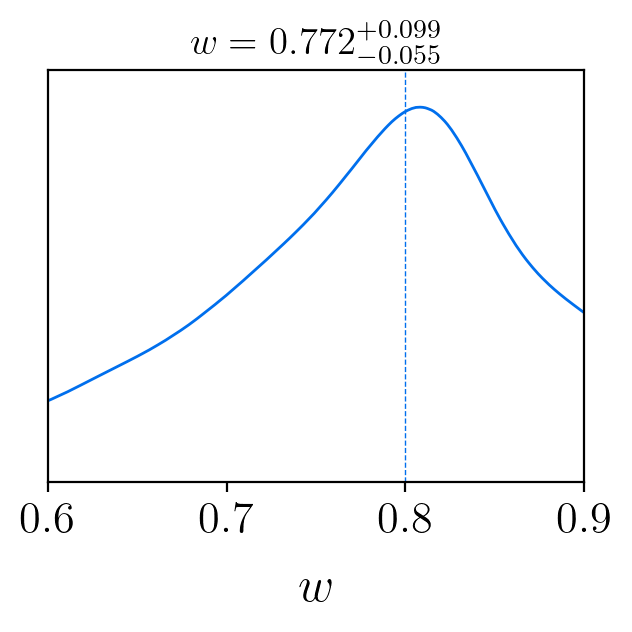

In [33]:
num_nodes = 5
names = ['w','log10_f_rh']
labels = ['w','\\log_{10} f_{rh}']
names+= [f'x_{i}' for i in range(num_nodes-2)]
labels+= [f'x_{i}' for i in range(num_nodes-2)]
names+= [f'y_{i}' for i in range(num_nodes)]
labels+= [f'y_{i}' for i in range(num_nodes)]
bounds = [[0.6,0.9],[-5.5,-4.5]]
bounds+= [[-5.0, -1.30103] for i in range(num_nodes-2)]
bounds+=[[-6,-2] for i in range(num_nodes)]
ranges = dict(zip(names,bounds))
print(ranges)
gd_samples = MCSamples(samples=samples_5['samples'], names=names, labels=labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=3.5)
markers = {'w': 0.8, 'log10_f_rh': -5.0}
# g.triangle_plot(gd_samples,filled=True,markers=markers,title_limit=1)
blue = '#006FED'
g.settings.title_limit_fontsize = 14
g.settings.axes_fontsize=16
g.settings.axes_labelsize=18
g.plot_1d(gd_samples, 'w', marker=0.8, marker_color=blue, colors=[blue],title_limit=1)
g.export('bpl_wfld_5_1D_w.pdf')

In [ ]:
from sigwfast_fortran import compute_rd

from sigwfast import sigwfast_mod as gw

def plot_functional_posterior(funcs,samples,k_arr = [], intervals = [95,68],ylabels=[r'$P_{\zeta}$',r'$\Omega_{\rm GW}$'],aspect_ratio = (6,4), interval_cols = [('r',0.2),('b',0.5)]):
    # given a function y = f(k|x) with x~Posterior samples, plot the posterior of y at k_arr, with symmetric credible intervals

    nfuncs = len(funcs)

    fig, ax = plt.subplots(1,nfuncs,figsize=(aspect_ratio[0]*nfuncs,aspect_ratio[1]),constrained_layout=True)
    if nfuncs == 1:
        ax = [ax]
    for i,func in enumerate(funcs):
        y = func(k_arr[i],samples) # so y should have shape (nsamples, nk)
        for j,interval in enumerate(intervals):
            y_low, y_high = np.percentile(y,[50-interval/2,50+interval/2],axis=0)
            ax[i].fill_between(k_arr[i],y_low,y_high,color=interval_cols[j])
        ax[i].plot(k_arr[i],np.median(y,axis=0),color='b',lw=2)
        ax[i].set_ylabel(ylabels[i])
    for x in ax:
        x.set(xscale='log',yscale='log',xlabel=r'$k$')
    return fig, ax 

OMEGA_R = 4.2 * 10**(-5)
CG = 0.39
rd_norm = CG*OMEGA_R 
nd = 150
from sigw_fast.libraries import sdintegral_numba as sd
left_node,right_node = -5.0, -1.30103
def compute_w(frequencies,samples,use_mp=False,nd=150,fref=1.):
    OmegaGW = []
    for sample in samples:
        w, log10_f_rh = sample[:2]
        free_nodes = sample[2:num_nodes-2]
        nodes = np.pad(free_nodes, (1,1), 'constant', constant_values=(left_node, right_node))
        vals = sample[num_nodes:]
        nd,ns1,ns2, darray,d1array,d2array, s1array,s2array = sd.arrays_w(w,frequencies,nd=nd)
        b = sd.beta(w)
        kernel1 = sd.kernel1_w(d1array, s1array, b)
        kernel2 = sd.kernel2_w(d2array, s2array, b)
        nk = len(frequencies)
        Integral = np.empty_like(frequencies)
        Integral = gw.compute_w_k_array(nodes = nodes, vals = vals, nk = nk,komega = frequencies, 
                                            kernel1 = kernel1, kernel2 = kernel2, d1array=d1array,
                                            s1array=s1array, d2array=d2array, s2array=s2array,
                                            darray=darray, nd = nd, ns1 = ns1, ns2 = ns2)
        f_rh = 10**log10_f_rh
        two_b = 2*b
        norm = rd_norm * (frequencies)**(-2*b) *  (f_rh/fref)**(two_b)   
        OmegaGW.append(norm * Integral)
    return np.array(OmegaGW) # OmegaGW has shape (nsamples, nk)

def compute_pz(k,samples):
    Pz = []
    for sample in samples:
        free_nodes = sample[2:num_nodes-2]
        nodes = np.pad(free_nodes, (1,1), 'constant', constant_values=(left_node, right_node))
        vals = sample[num_nodes:]
        res = gw.power_spectrum_k_array(nodes, vals, k)
        Pz.append(res)
    return np.array(Pz) # Pz has shape (nsamples, nk)


66000
33


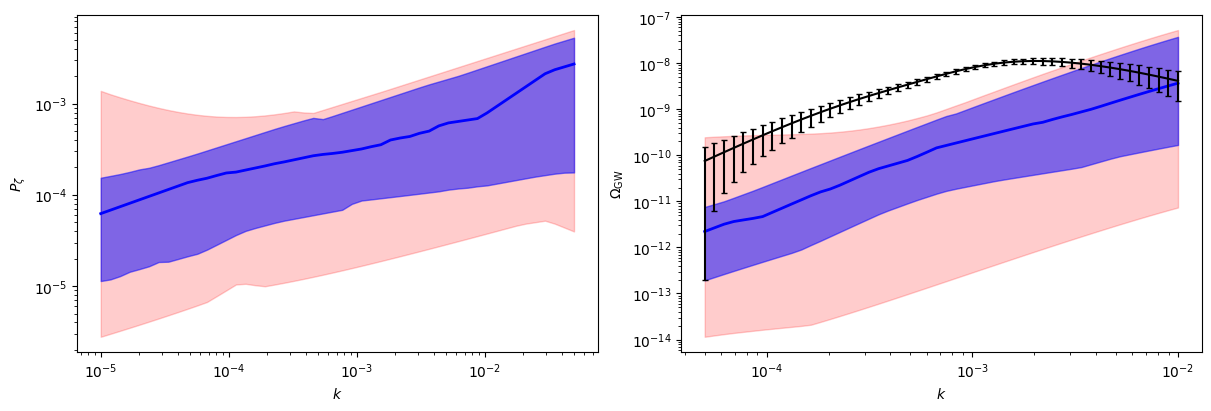

In [27]:
print(len(samples_4['samples']))
thinning = len(samples_4['samples']) // 32
thinned_samples = samples_4['samples'][::thinning]
print(len(thinned_samples))

data = np.load('./spectra_0p8.npz')
frequencies = data['frequencies']
gwb_model = 'bpl'
Omegas = data[f'gw_{gwb_model}'] 
kstar = 1e-3
omks_sigma = Omegas*( 0.1*(np.log(frequencies/kstar))**2 + 0.1) # 2% error at kstar + more towards edges
cov = np.diag(omks_sigma**2)
kpz = np.logspace(left_node,right_node,50)
k_arr = [kpz,frequencies]
fig, ax = plot_functional_posterior([compute_pz,compute_w],thinned_samples,k_arr = k_arr,intervals=[95,68],aspect_ratio=(6,4))
ax[1].errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt="", color='k', label='data',capsize=2,ecolor='k');


In [8]:
y = [[1,2] for i in range(3)]

y = np.array(y)
print(y)
print(y.shape)

[[1 2]
 [1 2]
 [1 2]]
(3, 2)
